# Nutrition Calculator  - Australian Food Composition Database

#### Mission Statement
The goal of this project is to analyze commonly consumed foods and gain a deep understanding of nutrition content of foods. We are often told to eat a balanced diet and get most of our vitamins and minerals from food sources when possible. However, rarely does anyone track these micronutrients. I want to gain an understanding of how easy it is to satisfy the recommended requirements and understand which foods make this easier. By finding the most nutrient dense foods, foods that have the rarest nutrients, and what foods together complete our daily requirements, I hope to build a complete lifestyle diet for myself.


#### Data sources
nutrition data: https://www.foodstandards.gov.au/science-data/monitoringnutrients/afcd 
<br> recommended intake data: https://www.myfooddata.com/articles/recommended-daily-intakes.php

#### To Do:<br>
<ins>Data Cleaning</ins>
- Advanced imputation method on micronutrient NaN's
- Add omega 6s properly
- [Expanded Model] Add nutrients back in with improved data imputation
    - Amino acids
    - Sugars
  
<br><ins>Modeling</ins>
- Use classifier trained on recipe file to make appropraite food portions
    - Use this to adjust lin prog restrictions
- Optimize lin prog w.r.t.
    - Protein
    - Fiber
    - Calories
- Make macro goals variable for function
- Classify healthy/unhealthy foods based on nutrient profile

<br><ins>Exploratory Data Analysis</ins>
- Do dot product of foods with DV
    - Adjust weights on nutrients
- How to interpret nutrient intakes
    - Daily? +/- certain amount given that you make it up in a day?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()
%matplotlib inline

In [2]:
# Regex debugger #
pattern = r'\s?\n\(.+\)'
df = pd.DataFrame({'Lysine \n(mg)':[1,2]})
new_cols = df.columns.str.replace(pattern, '', regex=True)
print(new_cols)

Index(['Lysine'], dtype='object')


In [3]:
# Import food and nutrition data #

food = pd.read_excel('Australian_Food_Composition_Database/Food Details.xlsx') 
nutrient = pd.read_excel('Australian_Food_Composition_Database/Nutrient file.xlsx',
                         sheet_name='All solids & liquids per 100g')

## Need to drop percent fatty acid content, not necessary for calculation and data cleaning causes repition ##
nutrient = nutrient.drop(columns = ['Total polyunsaturated fatty acids, equated (%T)', 
                          'Total long chain omega 3 fatty acids, equated \n(%T)'])
## Import Daily Value (DV) ##

dv = pd.read_csv('daily value.csv', index_col=0)
dv.head()

,RDI,DV,UL
Nutrient,,,
Calories,2000,2000,NaN
Fat,NaN,78g,NaN
Saturated Fat,NaN,20g,NaN
Cholesterol,NaN,300mg,NaN
Carbs,130g,275g,NaN


In [4]:
np.asarray(nutrient.columns)

array(['Public Food Key', 'Classification', 'Food Name',
       'Energy with dietary fibre, equated \n(kJ)',
       'Energy, without dietary fibre, equated \n(kJ)',
       'Moisture (water) \n(g)', 'Protein \n(g)', 'Nitrogen \n(g)',
       'Fat, total \n(g)', 'Ash \n(g)', 'Total dietary fibre \n(g)',
       'Alcohol \n(g)', 'Fructose \n(g)', 'Glucose \n(g)', 'Sucrose\n(g)',
       'Maltose \n(g)', 'Lactose \n(g)', 'Galactose \n(g)',
       'Maltotrios \n(g)', 'Total sugars (g)', 'Added sugars (g)',
       'Free sugars \n(g)', 'Starch \n(g)', 'Dextrin \n(g)',
       'Glycerol \n(g)', 'Glycogen \n(g)', 'Inulin \n(g)',
       'Erythritol \n(g)', 'Maltitol \n(g)', 'Mannitol \n(g)',
       'Xylitol \n(g)', 'Maltodextrin (g)', 'Oligosaccharides  \n(g)',
       'Polydextrose \n(g)', 'Raffinose \n(g)', 'Stachyose \n(g)',
       'Sorbitol \n(g)', 'Resistant starch \n(g)',
       'Available carbohydrate, without sugar alcohols \n(g)',
       'Available carbohydrate, with sugar alcohols \n(g)',
 

In [5]:
## Need to drop percent content columns. Not relevant to goal and causing duplicate columns later on ##
print("Number of columns in df before drop:", len(nutrient.columns))

percent_pattern = r'\(%\w+\)'
percent_cols = nutrient.columns.str.contains(percent_pattern)
print("Number of columns with % in header:", percent_cols.sum())
nutrient = nutrient.drop(columns = nutrient.columns[percent_cols])
print("Number of columns after dropping %:", len(nutrient.columns))

gN_pattern = r'\/gN'
gN_cols = nutrient.columns.str.contains(gN_pattern)
print("Number of columns with /gN in header:", gN_cols.sum())
nutrient = nutrient.drop(columns = nutrient.columns[gN_cols])
print("Number of columns after dropping /gN:", len(nutrient.columns))

Number of columns in df before drop: 291
Number of columns with % in header: 69
Number of columns after dropping %: 222
Number of columns with /gN in header: 18
Number of columns after dropping /gN: 204


In [6]:
nutrient.head()

,Public Food Key,Classification,Food Name,"Energy with dietary fibre, equated \n(kJ)","Energy, without dietary fibre, equated \n(kJ)",Moisture (water) \n(g),Protein \n(g),Nitrogen \n(g),"Fat, total \n(g)",Ash \n(g),...,Leucine \n(mg),Lysine \n(mg),Methionine \n(mg),Phenylalanine \n(mg),Proline \n(mg),Serine \n(mg),Threonine \n(mg),Tyrosine \n(mg),Tryptophan \n(mg),Valine \n(mg)
0,F002258,31302.0,"Cardamom seed, dried, ground",1236,1012,8.3,10.8,1.72,6.7,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155,NaN
1,F002893,31302.0,"Chilli (chili), dried, ground",1280,1002,10.8,13.4,2.14,14.3,11.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,NaN
2,F002963,31302.0,"Cinnamon, dried, ground",1004,579,10.6,4.0,0.64,1.2,3.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,NaN
3,F002970,31302.0,"Cloves, dried, ground",1389,1118,9.9,6.0,0.96,13.0,5.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,NaN
4,F003190,31302.0,"Coriander seed, dried, ground",1344,1009,8.9,12.4,1.98,17.8,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,178,NaN


## Data Cleaning

In [7]:
# Get rid of \n's from headers #
col_pattern = r'\s?\n\(.+\)'
nutr_cols = nutrient.columns.str.replace(col_pattern, '', regex=True)
new_cols = dict(zip(nutrient.columns, nutr_cols))
nutrient_clean = nutrient.rename(columns=new_cols)

# Change energy to calories #

fiber=True #toggle this to change how calories from fiber are calculated

if fiber==True:
    energy_cols = {'Energy with dietary fibre, equated': 'Calories'}
    nutrient_clean = nutrient_clean.rename(columns=energy_cols)
    nutrient_clean = nutrient_clean.drop(columns='Energy, without dietary fibre, equated')

else:
    energy_cols = {'Energy, without dietary fibre, equated': 'Calories'}
    nutrient_clean = nutrient_clean.rename(columns=energy_cols)
    nutrient_clean = nutrient_clean.drop(columns='Energy with dietary fibre, equated')

## Convert kJ to kCal ## 
nutrient_clean['Calories'] = nutrient_clean['Calories'].apply(lambda x: x/4.2)  #multiply kJ by this to get kcal

In [8]:
# Extract Units From Cols#

### Attempt 1 - Deleting###
"""The main plan is to delete units in table header. Because every unit in both datasets are metric, an inconsistency 
in units would manifest as a 3 orders of magnitude off which will be investigated in further analysis."""

# Get rid of (abbrev.)#
col_pattern = r' \(.+\)'
nutr_cols = nutrient_clean.columns.str.replace(col_pattern, '',regex=True)
new_cols = dict(zip(nutrient_clean.columns, nutr_cols))
nutrient_clean = nutrient_clean.rename(columns=new_cols)


In [9]:
# Need to change column names to be equivalent between food and DV #

## Vitamins ##
vitamins = {'Thiamin': 'Vitamin B1',
'Riboflavin': 'Vitamin B2',
'Niacin derived equivalents': 'Vitamin B3', 
'Pantothenic acid':'Vitamin B5',
'Pyridoxine':'Vitamin B6',
'Biotin': 'Vitamin B7',
'Total folates': 'Vitamin B9',
'Cobalamin': 'Vitamin B12',
'Vitamin A retinol equivalents':'Vitamin A',
'Vitamin D3 equivalents': 'Vitamin D'
           }
nutrient_clean = nutrient_clean.rename(columns=vitamins)

## Fat ##
nutrient_clean = nutrient_clean.rename(columns = {'Fat, total': 'Fat', 
                                                    'Total saturated fatty acids, equated': 'Saturated Fat',
                                                   'Total long chain omega 3 fatty acids, equated': 'Omega 3s'
                                                   })

### Adding omega 6s from manual Calc ###
### Assuming any polyunsaturated fat that isn't omega-3 is an omega-6
nutrient_clean['Omega 6s'] = round(nutrient_clean['Total polyunsaturated fatty acids, equated'] - nutrient_clean['Omega 3s']*0.001,2)

## Carbohydrates ##
carbs = {'Total sugars':'Sugar',
          'Total dietary fibre':'Fiber',
        'Available carbohydrate, with sugar alcohols':'Carbs'}
nutrient_clean = nutrient_clean.rename(columns=carbs)

## Misc Nutrients ##

misc_nutr = {'Cystine plus cysteine':'Cystine',
            }
nutrient_clean = nutrient_clean.rename(columns=misc_nutr)


#### Investigating NaN's

In [10]:
# Look at nutrient NaNs and determine whether or not they represent 0's

## Using leucine as an example 
leucine = nutrient_clean['Leucine']
print('Number of foods with null leucine values:', leucine.isnull().sum(),
      '\nNumber of foods with non-null:', leucine.notnull().sum())

notnull_leucine = nutrient_clean[leucine.notnull()]
null_leucine = nutrient_clean[leucine.isnull()]

"""The vast majority of foods are missing amino acid data. It would require combining an entire dataset which would
involve matching food names accurately, which is outside of the scope of this project. Either food with missing data 
must be excluded, or we must exclude these nutrients from the fitting criteria. In order to preserve the most data
possible, I an doing to drop the nutrients instead of the foods. For similar reasons as listed below, amino acids
are subcategories of protein, which is included in the data set. I do believe the fitting of these nutrients, like
many others being excluded, to be important and should be subject of an expansion to this study."""

# Make NaNs in food data 0 #
# nutrient_values_only = nutrient_values_only.fillna(0)


## Find columns with mostly NaN's and drop

mostly_empty = []

for cols in nutrient_clean:
    if nutrient_clean[cols].isnull().sum() > nutrient_clean[cols].notnull().sum():
        mostly_empty.append(cols)
        
nutrient_clean = nutrient_clean.drop(columns=mostly_empty)

Number of foods with null leucine values: 1435 
Number of foods with non-null: 181


In [11]:
# Dropping carb types #

"""In a similar vein, carbohydrates are non-essential nutrients (meaning there are no essential carbohydrates), so the
carbohydrate composition is not important information. However, it is best to have complex carbohydrates instead of 
simple ones like fructose and starches. For now, the total carbohydrates and total sugar will behave as a good proxy
measurement. Furthermore, having too many carbohydrate fitting variables, and too few protein and fat, could bias the
output. For these reasons, all but these columns will be dropped. Including these nutrients with fat and amino acid 
compositions would serve as a valuable expansion of this model."""

carb_cols = ['Starch', 'Sucrose', 'Glucose', 'Fructose', 'Lactose', 'Maltose']
dv = dv.drop(index=carb_cols)
nutrient_clean = nutrient_clean.drop(columns=carb_cols)

## Drop ash column, not a relevant nutrient ##
nutrient_clean = nutrient_clean.drop(columns='Ash')

In [12]:
def shared_columns(df1, df2):
    
    """Finds which columns in df1 are and are not shared with df2"""
    
    df1_cols = df1.columns
    df2_cols = df2.columns
    
    shared_cols = []
    diff_cols = []
    
    for cols in df1_cols:
        if cols in df2_cols:
            shared_cols.append(cols)
        else:
            diff_cols.append(cols)
    
    return shared_cols, diff_cols

In [13]:
## Find DV columns that aren't equal to nutrient cols ##

dv_clean = dv.rename(index={'Lutein+zeazanthin': 'Lutein'})
nutr_cols = nutrient_clean.columns
dv_shared = shared_columns(dv_clean.transpose(), nutrient_clean)


"""This data does not exist in the food list df, therefore we will ignore these nutrients. Water is a 
nutrient that should be satisfied outside of food consumption. Therefore, it should be excluded
from the analysis. Furthermore, the remaining incongruent sets are non-essential amino acids which can
be produced in the human body, making it less important for consumption. Vitamin K and Choline
are essential in the human diet. However, the food data set does not have these included. This data could 
be imputed in the event of expanding the model for a more robust study."""

dv_clean = dv_clean.drop(index=dv_shared[1])
print("Dropping columns:", dv_shared[1])
dv_shared_dropped = shared_columns(dv_clean.transpose(), nutrient_clean)

print("Shared columns:", len(dv_shared_dropped[0]),"\nDifferent columns:", len(dv_shared_dropped[1]))



Dropping columns: ['Vitamin K', 'Choline', 'Lycopene', 'Lutein', 'Ash', 'Water', 'Galactose', 'Histidine', 'Threonine', 'Isoleucine', 'Lysine', 'Leucine', 'Methionine', 'Cystine', 'Phenylalanine', 'Tyrosine', 'Valine', 'Arginine', 'Alanine', 'Aspartic Acid', 'Glutamic Acid', 'Glycine', 'Proline', 'Serine', 'Hydroxyproline']
Shared columns: 33 
Different columns: 0


In [14]:
# Find nutrient columns that aren't in the DV columns #

nutr_cols = nutrient_clean.columns
nutr_shared = shared_columns(nutrient_clean, dv_clean.transpose())
print("Shared columns:", len(nutr_shared[0]),"\nDifferent columns:", len(nutr_shared[1]))

"""Much of the remaining dataset is anti-nutrients, subcategories of nutrients which are encapsulated by other
nutrients, and nutrients which have no recommended value. Currently, anti-nutrients are not in the scope of this
study but could be a valuable addition later. Therefore, I will drop all excess columns except the food name
column."""

food_name = nutrient_clean['Food Name']
print("Dropping excess nutrient columns", nutr_shared[1])

nutrient_values_only = nutrient_clean.drop(columns=nutr_shared[1])/100 # From per 100g to per 1g
nutr_shared = shared_columns(dv_clean.transpose(), nutrient_values_only)
print("Shared columns:", len(nutr_shared[0]),"\nDifferent columns:", len(nutr_shared[1]))
# print(nutr_shared[1])

Shared columns: 33 
Different columns: 47
Dropping excess nutrient columns ['Public Food Key', 'Classification', 'Food Name', 'Moisture', 'Nitrogen', 'Alcohol', 'Added sugars', 'Free sugars', 'Available carbohydrate, without sugar alcohols', 'Retinol', 'Alpha-carotene', 'Beta-carotene', 'Cryptoxanthin', 'Beta-carotene equivalents', 'Niacin', 'Niacin derived from tryptophan', 'Folate, natural', 'Folic acid', 'Dietary folate equivalents', 'Cholecalciferol', 'Ergocalciferol', '25-hydroxy cholecalciferol', '25-hydroxy ergocalciferol', 'Alpha tocopherol', 'C14', 'C15', 'C16', 'C17', 'C18', 'C22', 'C14:1', 'C16:1', 'C18:1', 'Total monounsaturated fatty acids, equated', 'C18:2w6', 'C18:3w3', 'C18:3w6', 'C20:2w6', 'C20:3w6', 'C20:4w6', 'C20:5w3', 'C22:5w3', 'C22:4w6', 'C22:6w3', 'Total polyunsaturated fatty acids, equated', 'Total trans fatty acids, imputed', 'Caffeine']
Shared columns: 33 
Different columns: 0


In [15]:
nutrient_values_only.head()

,Calories,Protein,Fat,Fiber,Sugar,Carbs,Calcium,Copper,Iodine,Iron,...,Vitamin B12,Vitamin B9,Vitamin C,Vitamin D,Vitamin E,Saturated Fat,Omega 3s,Cholesterol,Tryptophan,Omega 6s
0,2.942857,0.108,0.067,0.280,0.044,0.344,3.83,NaN,0.000,0.1397,...,0.0,0.03,0.21,0.0,0.0285,0.0220,0.00000,0.0,1.55,0.0139
1,3.047619,0.134,0.143,0.348,0.072,0.149,3.30,NaN,0.023,0.1730,...,0.0,0.28,0.01,0.0,0.3814,0.0206,0.00000,0.0,0.69,0.0669
2,2.390476,0.040,0.012,0.531,0.022,0.275,10.02,NaN,0.001,0.0832,...,0.0,0.06,0.04,0.0,0.0232,0.0062,0.00000,0.0,0.49,0.0012
3,3.307143,0.060,0.130,0.339,0.024,0.316,6.32,NaN,0.507,0.1183,...,0.0,0.25,0.00,0.0,0.0882,0.0549,2.66581,0.0,0.30,0.0476
4,3.200000,0.124,0.178,0.419,0.024,0.084,7.09,NaN,0.023,0.1632,...,0.0,0.00,0.21,0.0,0.0091,0.0103,0.00000,0.0,1.78,0.0182


In [16]:
# Extract Units From DV #

unit_pattern = r'\d+(\w+)'
number_pattern = r'(\d+.?\d+)'
dv_clean['RDI units'] = dv_clean['RDI'].str.extract(unit_pattern)
dv_clean['RDI'] = dv_clean['RDI'].str.extract(number_pattern)
dv_clean['DV units'] = dv_clean['DV'].str.extract(unit_pattern)
dv_clean['DV'] = dv_clean['DV'].str.extract(number_pattern)

# Make numeric entries numeric type
dv_clean['DV'] = pd.to_numeric(dv_clean['DV'])
dv_clean['RDI'] = pd.to_numeric(dv_clean['RDI'])

# Convert mcg into mg, like it is in main table
mcg_pattern = r'mcg'
dv_clean.loc[dv_clean['DV units'].str.contains(mcg_pattern, na=False) | dv_clean['RDI units'].str.contains(mcg_pattern, na=False), ['DV', 'RDI'] ] /= 1000


In [17]:
"""Let's combine the entries in RDI and DV to create a daily value with few NaNs, taking the highest value
Note: isnan() is vectorized so I might be able to get rid of loop."""

dv_col = dv_clean['DV']
rdi_col = dv_clean['RDI']
dv_rdi_combined = []

for dv, rdi in zip(dv_col,rdi_col):
    if np.isnan(dv) and not np.isnan(rdi):
        dv_rdi_combined.append(rdi)
    
    elif not np.isnan(dv) and np.isnan(rdi):
        dv_rdi_combined.append(dv)
    
    elif np.isnan(dv) and np.isnan(rdi):
        dv_rdi_combined.append(dv)
        
    elif not np.isnan(dv) and not np.isnan(rdi):
        dv_rdi_combined.append(max(dv,rdi))

dv_clean['DV and RDI, Highest'] = dv_rdi_combined

#### Impute Missing Vitamin B5 Value
Sources: <br>
Vitamin B5: https://health.clevelandclinic.org/vitamin-b5-pantothenic-acid <br>

In [18]:
# Impute DV/RDI  #
dv_clean.loc['Vitamin B5', 'DV and RDI, Highest'] = 5.0
dv_clean.loc['Vitamin B5', 'DV units'] = 'mg'


In [19]:
dv_clean['DV and RDI, Highest']

Nutrient
Calories         2000.0000
Fat                78.0000
Saturated Fat      20.0000
Cholesterol       300.0000
Carbs             275.0000
Fiber              38.0000
Sugar              50.0000
Protein            56.0000
Vitamin A           3.0000
Vitamin B1          1.2000
Vitamin B2          1.3000
Vitamin B3         16.0000
Vitamin B5          5.0000
Vitamin B6          1.7000
Vitamin B9          0.4000
Vitamin B12         0.0024
Vitamin C          90.0000
Vitamin D           0.0200
Vitamin E          15.0000
Calcium          1300.0000
Copper              0.9000
Iodine              0.1500
Iron               18.0000
Magnesium         420.0000
Manganese           2.3000
Phosphorus       1250.0000
Potassium        4700.0000
Selenium            0.0550
Sodium           2300.0000
Zinc               11.0000
Omega 3s            1.6000
Omega 6s           17.0000
Tryptophan        280.0000
Name: DV and RDI, Highest, dtype: float64

#### Repeat Column Name Sanity Check

In [20]:
a = {}
for nut in nutrient_clean.columns:
    if nut in a:
        a[nut] +=1
    else:
        a[nut] = 1

In [21]:
b = 0
for keys, vals in a.items():
    if vals > 1:
        print('Repeat column')
        b+=1
if b == 0:
    print('No repeat columns')

No repeat columns


In [22]:
nutrient_reduced = nutrient_values_only.copy()
nutrient_reduced['Food Name'] = food_name


In [23]:
nutrient_reduced.isnull().sum()

Calories           0
Protein            0
Fat                0
Fiber              0
Sugar              0
Carbs              0
Calcium            0
Copper           361
Iodine             0
Iron               0
Magnesium          0
Manganese        392
Phosphorus         0
Potassium          0
Selenium           0
Sodium             0
Zinc               0
Vitamin A          0
Vitamin B1         0
Vitamin B2         0
Vitamin B3         0
Vitamin B5       574
Vitamin B6         0
Vitamin B12        0
Vitamin B9         0
Vitamin C          0
Vitamin D          0
Vitamin E          0
Saturated Fat      0
Omega 3s           0
Cholesterol        0
Tryptophan         0
Omega 6s           0
Food Name          0
dtype: int64

Mean is 0.005043282149712093 and StdDev is 0.006182029089326126


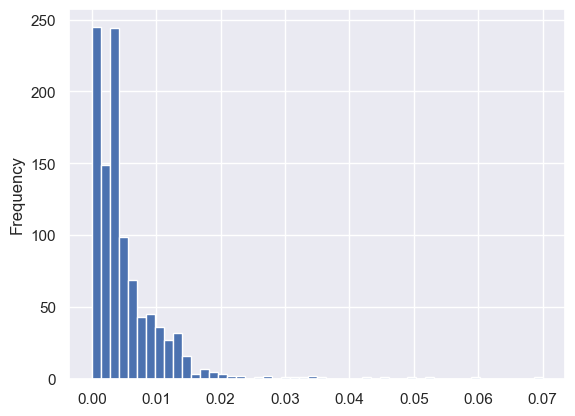

In [24]:
nutr_has_b5 = nutrient_reduced[nutrient_reduced['Vitamin B5'].notnull()]
high_b5 = nutr_has_b5[nutr_has_b5['Vitamin B5'] > 0.005]['Vitamin B5']
b5 = nutr_has_b5['Vitamin B5']
b5.plot.hist(bins=50)
print(f'Mean is {np.mean(b5)} and StdDev is {np.std(b5)}')

In [25]:
nutr_no_B5 = nutrient_reduced[nutrient_reduced['Vitamin B5'].isnull()]
# np.asarray(nutr_no_B5['Food Name'])

In [26]:
# Fill in NaNs with 0s and move on#
"""Must address this later"""
nutrient_values_only = nutrient_values_only.fillna(0.0)
nutrient_reduced = nutrient_reduced.fillna(0.0)

## Exploratory Data Analysis

Goals:
1. Explore micronutrient content in foods.
2. Create micronutrient score, find ratio of micros to macros

In [28]:
dv_clean

,RDI,DV,UL,RDI units,DV units,"DV and RDI, Highest"
Nutrient,,,,,,
Calories,2000.0000,2000.0000,NaN,0,0,2000.0000
Fat,NaN,78.0000,NaN,NaN,g,78.0000
Saturated Fat,NaN,20.0000,NaN,NaN,g,20.0000
Cholesterol,NaN,300.0000,NaN,NaN,mg,300.0000
Carbs,130.0000,275.0000,NaN,g,g,275.0000
Fiber,38.0000,28.0000,NaN,g,g,38.0000
Sugar,NaN,50.0000,NaN,NaN,g,50.0000
Protein,56.0000,50.0000,NaN,g,g,56.0000
Vitamin A,0.9000,3.0000,3000mcg (RAE),mcg,IU,3.0000


In [29]:
# Make micro nutrient df #

macros = ['Calories', 'Carbs', 'Protein', 'Fat', 'Sugar', 'Saturated Fat'] # Not dropping omega fatty acids
dv = dv_clean['DV and RDI, Highest']
micro_recommend = dv.drop(index=macros)
micro_nutrient = nutrient_reduced.drop(columns=macros)

In [80]:
# Match nutrient index orders
micro_matrix_combo = micro_nutrient.transpose()
micro_matrix_combo = micro_matrix_combo.merge(micro_recommend,left_index=True, right_index=True)
micro_matrix_combo.head()

,0,1,2,3,4,5,6,7,8,9,...,1607,1608,1609,1610,1611,1612,1613,1614,1615,"DV and RDI, Highest"
Fiber,0.28,0.348,0.531,0.339,0.419,0.105,0.532,0.476,0.141,0.05,...,0.099,0.027,0.038,0.011,0.016,0.013,0.01,0.014,0.012,38.00
Calcium,3.83,3.3,10.02,6.32,7.09,9.31,5.25,1.76,1.14,1.6,...,2.89,0.03,0.85,0.18,0.25,0.2,0.16,0.23,0.18,1300.00
Copper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0041,...,0.0,0.0,0.0,0.00066,0.00095,0.00079,0.0,0.0,0.0,0.90
Iodine,0.0,0.023,0.001,0.507,0.023,0.136,0.0,0.023,0.124,0.0,...,0.066,0.007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15
Iron,0.1397,0.173,0.0832,0.1183,0.1632,0.6636,0.191,0.3353,0.198,0.07,...,0.0298,0.028,0.03,0.005,0.0071,0.0056,0.004,0.0057,0.0045,18.00


In [81]:
def column_norm(column):
    return column[i]/np.sqrt(np.dot(col,col))

In [84]:
np.asarray(micro_matrix_combo.iloc[:,:-1]

array([[0.28, 0.348, 0.531, ..., 0.01, 0.013999999999999999, 0.012],
       [3.83, 3.3, 10.02, ..., 0.16, 0.23, 0.18],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [1.55, 0.69, 0.49, ..., 0.25, 0.35, 0.29],
       [0.0139, 0.0669, 0.0012, ..., 0.0, 0.0, 0.0]], dtype=object)

In [89]:
# Nutrient density calculation #
"""Making every food a unit vector then doing a dot product with the nutrient column."""
micro_matrix_combo = micro_matrix_combo.rename(columns=food_name)
micro_matrix_unit = micro_matrix_combo.copy()#np.linalg.norm(micro_matrix_combo.iloc[:,:-1], axis=0)
for col in micro_matrix_unit:
    column = micro_matrix_unit[col]
    micro_matrix_norm[col] = column/np.sqrt(np.dot(column,column))

# micro_matrix_unit= np.divide(micro_matrix_combo.iloc[:,:-1], micro_matrix_norm)
micro_matrix_norm

,"Cardamom seed, dried, ground","Chilli (chili), dried, ground","Cinnamon, dried, ground","Cloves, dried, ground","Coriander seed, dried, ground","Cumin (cummin) seed, dried, ground",Curry powder,"Fenugreek seed, dried","Ginger, dried, ground",Mustard powder,...,"Vine leaf, grape, canned","Water chestnut, peeled, canned, drained","Watercress, raw","Zucchini, green skin, fresh, unpeeled, raw","Zucchini, green skin, fresh, unpeeled, fried, no added fat","Zucchini, green skin, fresh, unpeeled, boiled, drained","Zucchini, golden, fresh, unpeeled, raw","Zucchini, golden, fresh, unpeeled, fried, no added fat","Zucchini, golden, fresh, unpeeled, boiled, drained","DV and RDI, Highest"
Fiber,0.022794,0.00809,0.048407,0.026224,0.026931,0.004916,0.03893,0.051032,0.010346,0.00458,...,0.003405,0.0262,0.005185,0.005489,0.005647,0.006083,0.004205,0.004148,0.004729,6.826311e-03
Calcium,0.311786,0.076718,0.913447,0.488891,0.4557,0.435881,0.384177,0.188688,0.083646,0.146553,...,0.099387,0.029111,0.11597,0.089816,0.088231,0.093577,0.06728,0.068146,0.070929,2.335317e-01
Copper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000376,...,0.0,0.0,0.0,0.000329,0.000335,0.00037,0.0,0.0,0.0,1.616758e-04
Iodine,0.0,0.000535,0.000091,0.03922,0.001478,0.006367,0.0,0.002466,0.009098,0.0,...,0.00227,0.006793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.694596e-05
Iron,0.011372,0.004022,0.007585,0.009151,0.010489,0.031069,0.013977,0.035947,0.014528,0.006412,...,0.001025,0.02717,0.004093,0.002495,0.002506,0.00262,0.001682,0.001689,0.001773,3.233516e-03
Magnesium,0.18642,0.034639,0.054697,0.200353,0.212103,0.171356,0.1866,0.20477,0.15702,0.283947,...,0.004815,0.038815,0.03138,0.079836,0.081172,0.084219,0.04205,0.04148,0.043346,7.544870e-02
Manganese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00174,...,0.0,0.0,0.0,0.000674,0.000681,0.000753,0.0,0.0,0.0,4.131715e-04
Phosphorus,0.144903,0.069744,0.058344,0.08045,0.262879,0.233625,0.268558,0.317339,0.123268,0.668649,...,0.011693,0.18437,0.042295,0.169652,0.169403,0.168439,0.142971,0.142217,0.141859,2.245497e-01
Potassium,0.910935,0.453336,0.39291,0.789034,0.814346,0.837117,0.856166,0.825511,0.968535,0.595373,...,0.009973,0.970367,0.777682,0.938073,0.945833,0.94045,0.967155,0.971819,0.969368,8.443069e-01
Selenium,0.009525,0.004743,0.002826,0.00557,0.01684,0.002435,0.02949,0.006754,0.040943,0.146553,...,0.0,0.006793,0.000819,0.0,0.0,0.0,0.0,0.0,0.0,9.880187e-06


In [76]:
micro_matrix_combo.iloc[:,:-1]

,"Cardamom seed, dried, ground","Chilli (chili), dried, ground","Cinnamon, dried, ground","Cloves, dried, ground","Coriander seed, dried, ground","Cumin (cummin) seed, dried, ground",Curry powder,"Fenugreek seed, dried","Ginger, dried, ground",Mustard powder,...,"Tomato, whole, canned in tomato juice, drained","Vine leaf, grape, canned","Water chestnut, peeled, canned, drained","Watercress, raw","Zucchini, green skin, fresh, unpeeled, raw","Zucchini, green skin, fresh, unpeeled, fried, no added fat","Zucchini, green skin, fresh, unpeeled, boiled, drained","Zucchini, golden, fresh, unpeeled, raw","Zucchini, golden, fresh, unpeeled, fried, no added fat","Zucchini, golden, fresh, unpeeled, boiled, drained"
Fiber,0.28,0.348,0.531,0.339,0.419,0.105,0.532,0.476,0.141,0.05,...,0.013,0.099,0.027,0.038,0.011,0.016,0.013,0.01,0.014,0.012
Calcium,3.83,3.3,10.02,6.32,7.09,9.31,5.25,1.76,1.14,1.6,...,0.27,2.89,0.03,0.85,0.18,0.25,0.2,0.16,0.23,0.18
Copper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0041,...,0.0,0.0,0.0,0.0,0.00066,0.00095,0.00079,0.0,0.0,0.0
Iodine,0.0,0.023,0.001,0.507,0.023,0.136,0.0,0.023,0.124,0.0,...,0.0,0.066,0.007,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Iron,0.1397,0.173,0.0832,0.1183,0.1632,0.6636,0.191,0.3353,0.198,0.07,...,0.002,0.0298,0.028,0.03,0.005,0.0071,0.0056,0.004,0.0057,0.0045
Magnesium,2.29,1.49,0.6,2.59,3.3,3.66,2.55,1.91,2.14,3.1,...,0.09,0.14,0.04,0.23,0.16,0.23,0.18,0.1,0.14,0.11
Manganese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019,...,0.0004,0.0,0.0,0.0,0.00135,0.00193,0.00161,0.0,0.0,0.0
Phosphorus,1.78,3.0,0.64,1.04,4.09,4.99,3.67,2.96,1.68,7.3,...,0.14,0.34,0.19,0.31,0.34,0.48,0.36,0.34,0.48,0.36
Potassium,11.19,19.5,4.31,10.2,12.67,17.88,11.7,7.7,13.2,6.5,...,1.7,0.29,1.0,5.7,1.88,2.68,2.01,2.3,3.28,2.46
Selenium,0.117,0.204,0.031,0.072,0.262,0.052,0.403,0.063,0.558,1.6,...,0.004,0.0,0.007,0.006,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
micro_matrix_norm = np.linalg.norm(micro_matrix_combo[:,-1:], axis=0)
micro_matrix_combo = micro_matrix_combo.map(lambda x: x/micro_matrix_norm[x.name])
micro_matrix_combo.head()

In [37]:
x = list((0,0.001,1))/np.sqrt(0.001**2+1**2)
y =  list((0,0,1))
np.dot(x,y)

0.999999500000375

In [47]:
a = np.array([[1,2,3],
              [1,2,3],
              [1,2,3]])

a[:,:-1]

array([[1, 2],
       [1, 2],
       [1, 2]])

In [ ]:
break

## Attempting to find arbitrary solutions to matrix equation
The goal of this section is to output any set of foods that will satisfy the daily goals.

This problem is so much more complex I than I really imagined. In truth, there are infinitely many solutions and so I thought I would be able to explore this space.

#### Mathematic Model
The tables above leave us with a linear equation of the form:
$$a_{1}f_{1} + ... + a_{m}f_{m} = v_{T}$$ 
where, $$a_{k} \in \mathbb{R}, f_{k} \in V$$ 
and, $$k \in {0,...,m}$$

Here the daily value required is represented by the vector $v_T$, with entries in the vector being daily value nutrient limits.

The list of vectors, $f$, represent the nutrient profile of a given food, with its $k^{th}$ element being the $k^{th}$ nutrient in $v_T$.

The scalars, $a$, are the amounts, or portion size, of the foods in $f$ that satisfy the equation above. This equation can be written in its matrix form:

$$Fa = v_T$$

By solving the equation for the amounts $a$, we can get a list of foods that satisfy our days nutrition needs. Thus, satisfying a major goal of this project.

### 1. Try to generate a smaller tensor and find feasible region inside it
Problem:Generating combinations results in 33*1616^1000 combinations

In [ ]:
# a_grid = np.arange(0,1000,1)
# # food_matrix = np.asarray(nutrient_values_only.transpose())
# food_amount_tensor = np.outer(food_matrix, a_grid)
# food_amount_tensor.shape


In [ ]:
# Match nutrient index orders
food_matrix = nutrient_values_only.transpose()
food_matrix = food_matrix.merge(dv_clean['DV and RDI, Highest'],left_index=True, right_index=True)
# df.merge(s, left_index=True, right_index=True)
food_matrix.head()

In [ ]:
# Set the inequalities #
"""Note: For now we will ignore dietary cholesterol due to it mostly being seen as benign."""
"""Note: There are few upper limits, so they are set arbitrarily high unless otherwise specified.""" 

## Set mins ##
v_min = food_matrix['DV and RDI, Highest'] #most values are a minimum, start here
v_min['Sugar'] = 0 #Sugar in DV is a max
v_min['Saturated Fat'] = 0 #Sat Fat in DV is a max
v_min['Calories'] = 1700 #Caution on the lower side
v_min['Cholesterol'] = 0

## Set carbs and fat inequality to be +/- 20% RDI/DV
v_min['Carbs'] = food_matrix.loc['Carbs', 'DV and RDI, Highest']*.80
v_min['Fat'] = food_matrix.loc['Carbs', 'DV and RDI, Highest']*.80

## Set maxs ##
v_max = food_matrix['DV and RDI, Highest'].copy()*10000 #most values are a minimum, set max to be arbitrarily high
v_max['Sugar'] = food_matrix.loc['Sugar', 'DV and RDI, Highest'] # Sugar in DV is a max
v_max['Saturated Fat'] =  food_matrix.loc['Saturated Fat', 'DV and RDI, Highest']# Sat Fat in DV is a max
v_max['Calories'] = 2100 # A little over is OK


## Set carbs and fat inequality to be +/- 20% RDI/DV
v_max['Carbs'] = food_matrix.loc['Carbs', 'DV and RDI, Highest']*1.20
v_max['Fat'] = food_matrix.loc['Carbs', 'DV and RDI, Highest']*1.20

# Drop DV/RDI column before calculation
food_matrix = food_matrix.drop(columns = 'DV and RDI, Highest')

In [ ]:
# Trying to sum every possible combination of food and amount for a single nutrient
from itertools import product

def sum_without_same_row_elements(matrix):
    num_rows, num_cols = matrix.shape
    
    # Generate all combinations of selecting one element per row
    row_combinations = product(range(num_cols), repeat=num_rows)
    
    # Compute the sum for each combination
    sums = []
    i=0
    for _ in row_combinations:
        i+=1
    print(i)
    # for combination in row_combinations:
    #     i+=1
    #     print(f"Attempt {i}")
    #     total = sum(matrix[row, col] for row, col in enumerate(combination))
    #     sums.append((combination, total))
    
    # return sums



In [ ]:
import itertools

def generate_sums(vectors):
    all_combinations = itertools.product(*vectors)
    sums = [sum(combination) for combination in all_combinations]
    return sums

# Example usage:
vectors = [
    [1, 2, 3, 4],
    [4, 5, 6, 4],
    [7, 8, 9, 4]
]

sums = generate_sums(vectors)
print(len(sums))


### 2. Find random solutions to the inequality
Problem: Creates random amounts of all foods never seems to find a solution

In [ ]:
# Set the inequalities #
"""Note: For now we will ignore dietary cholesterol due to it mostly being seen as benign."""
"""Note: There are few upper limits, so they are set arbitrarily high unless otherwise specified.""" 

## Set mins ##
v_min = dv_clean['DV and RDI, Highest'].copy() #most values are a minimum, start here
v_min['Sugar'] = 0 #Sugar in DV is a max
v_min['Saturated Fat'] = 0 #Sat Fat in DV is a max
v_min['Calories'] = 1700 #Caution on the lower side
v_min['Cholesterol'] = 0

## Set carbs and fat inequality to be +/- 20% RDI/DV
v_min['Carbs'] = dv_clean.loc['Carbs', 'DV and RDI, Highest']*.80
v_min['Fat'] = dv_clean.loc['Carbs', 'DV and RDI, Highest']*.80

## Set maxs ##
v_max = dv_clean['DV and RDI, Highest'].copy()*10000 #most values are a minimum, set max to be arbitrarily high
v_max['Sugar'] = dv_clean.loc['Sugar', 'DV and RDI, Highest'] # Sugar in DV is a max
v_max['Saturated Fat'] =  dv_clean.loc['Saturated Fat', 'DV and RDI, Highest']# Sat Fat in DV is a max
v_max['Calories'] = 2100 # A little over is OK


## Set carbs and fat inequality to be +/- 20% RDI/DV
v_max['Carbs'] = dv_clean.loc['Carbs', 'DV and RDI, Highest']*1.20
v_max['Fat'] = dv_clean.loc['Carbs', 'DV and RDI, Highest']*1.20


In [ ]:
# Generate random solutions #
"""This approach is indefinite and takes forever. Also it will likely produce too many """
def generate_random_solutions(F, v_min, v_max, a_max, num_samples=1):
    """Generates a random a vector until one satisfies v_min < Fa < v_max"""
    num_vars = F.shape[1]  # Number of variables (components of vector a)
    solutions = []
    for _ in range(num_samples):
        valid = False
        attempt_count=0
        while not valid:
            # Generate a random vector a within the given bounds
            a = np.array([np.random.randint(0, a_max)for i in range(num_vars)])
     
            # Check if random guess satisfies inequality
            if np.all(np.dot(F, a) < v_max) and np.all(np.dot(F,a) > v_min):
                valid = True
                solutions.append(a)
            elif attempt_count < 1e3:
                attempt_count += 1
            else:
                print(f'No solution found after {attempt_count} attempts')
                valid = True
                
    
    return solutions

In [ ]:
# Generate a random food and add back food names #
import time
start_time = time.time()
random_food_solution = generate_random_solutions(F=nutrient_values_only.transpose(), v_min=v_min, v_max=v_max, a_max=1000)
random_food_solution
print("--- %s seconds ---" % (time.time() - start_time))


In [ ]:
# random_food = pd.DataFrame({food_name:random_food_solutions})
# random_food.head()

### 2.2 Selecting points that pass this criteria

In [ ]:
# Define the bounds for generating random solutions
bounds = [0,1000]

# Function to generate random points within bounds
def generate_random_points(matrix, num_points, bounds):
    dim = matrix.shape[1]
    random_points = np.random.rand(num_points, dim)
    for i in range(dim):
        lower, upper = bounds
        random_points[:, i] = lower + random_points[:, i] * (upper - lower)
    return random_points

# Generate random points
num_points = 1000
random_points = generate_random_points(nutrient_values_only.transpose(), num_points, bounds)

# Filter points that satisfy the inequality Ma < v
valid=True # Toggle to run loop below
while valid == False:
   
    feasible_points = [a for a in random_points if np.all(np.dot(nutrient_values_only.transpose(), a) < v_max) 
                   and np.all(np.dot(nutrient_values_only.transpose(), a) > v_min)]
    if len(feasible_points) > 0:
        valid = True


# Print feasible points
# print("Feasible points:",feasible_points)


### 3. Using least squares to find optimal solution to the linear equation
Problem: Only works with small data sets, otherwise all values are 0 and residual is astronomical. Doesn't work with inequalities

In [ ]:
## Sanity check, lets find a solution using select part of ##
from scipy.optimize import nnls
import random

v_target = dv_clean['DV and RDI, Highest'].copy()
v_target_reduced = np.asarray(v_target.loc[['Calories', 'Fat', 'Carbs','Protein']])
food_df_reduced = nutrient_values_only[['Calories', 'Fat', 'Carbs','Protein']]
food_matrix_reduced = np.asarray(food_df_reduced.transpose())

# v_target = np.asarray(dv_clean['DV and RDI, Highest'])
# food_matrix = np.asarray(nutrient_values_only.transpose())

food, res = nnls(A=food_matrix_reduced, b=v_target_reduced)
nonzero = []
for i, f in enumerate(food):
    if f > 0.001:
        nonzero.append([i,f])
nonzero = np.asarray(nonzero)
food_name[nonzero[:,0]]
today_you_eat = pd.DataFrame({'Food': food_name[nonzero[:,0]], 'Amount (g)': nonzero[:,1]*100})
res

In [ ]:
today_you_eat

In [ ]:
v_target_reduced

In [ ]:

def rand_lstsq_solution(F, v_target, num_samples,seed=False):
    if seed == True:
        random.seed(42)
    sample = [i for i in range(F.shape[1])]
    rand_ind = random.sample(sample, num_samples)
    rand_names = food_name[rand_ind]
    rand_solution, res = nnls(A=F[:,rand_ind], b=v_target)
    
    return [rand_names, rand_solution, res]


    


In [ ]:
# Generate random foods and find closest solution

v_target = dv_clean['DV and RDI, Highest'].copy()
food_matrix = np.asarray(nutrient_values_only.transpose())

food_amounts = rand_lstsq_solution(food_matrix, np.asarray(v_target), 1616)
today_you_eat = pd.DataFrame({'Food': food_amounts[0], 'Amount (g)': food_amounts[1][0]})


In [ ]:
food_amounts[2]

In [ ]:
today_you_eat

### 4. Using linear programming to generate a set of feasible solutions
Problem: Can only find single solution, of which must be optimized to another variable, instead of arbitrary solution in feasible region. 

#### Mathematic Model
The tables above leave us with a linear equation of the form:
$$a_{1}f_{1} + ... + a_{m}f_{m} = v_{T}$$ 
where, $$a_{k} \in \mathbb{R}, f_{k} \in V$$ 
and, $$k \in {0,...,m}$$

Here the daily value required is represented by the vector $v_T$, with entries in the vector being daily value nutrient limits.

The list of vectors, $f$, represent the nutrient profile of a given food, with its $k^{th}$ element being the $k^{th}$ nutrient in $v_T$.

The scalars, $a$, are the amounts, or portion size, of the foods in $f$ that satisfy the equation above. This equation can be written in its matrix form:

$$Fa = v_T$$

By solving the equation for the amounts $a$, we can get a list of foods that satisfy our days nutrition needs. Thus, satisfying a major goal of this project.

However, with foods this will rarely result in an exact solution. Instead, we want to find a set of solutions that satisfy the inequality,

\begin{array}{r@{\quad}r@{\quad}>{\dotfill}l}
a_{1}f_{1,1} + \ldots + a_{m}f_{m,1} & > & v_{T, 1} \\
\ &  \vdots \\
a_{1}f_{1,n} + \ldots + a_{m}f_{m,n} & > & v_{T, n}
\end{array}

To do this, we can use a method called "Linear Programming." We will create a feasible region using these inequalities and explore it. Furthermore, we can explore this region to optimize for different nutrients, like minimizing calories or maximizing protein.

In [ ]:
# Set the inequalities #
"""Note: For now we will ignore dietary cholesterol due to it mostly being seen as benign."""
"""Note: There are few upper limits, so they are set arbitrarily high unless otherwise specified.""" 

## Set mins ##
v_min = dv_clean['DV and RDI, Highest'].copy() #most values are a minimum, start here
v_min['Sugar'] = 0 #Sugar in DV is a max
v_min['Saturated Fat'] = 0 #Sat Fat in DV is a max
v_min['Calories'] = 1700 #Caution on the lower side
v_min['Cholesterol'] = 0

## Set carbs and fat inequality to be +/- 20% RDI/DV
v_min['Carbs'] = dv_clean.loc['Carbs', 'DV and RDI, Highest']*.80
v_min['Fat'] = dv_clean.loc['Carbs', 'DV and RDI, Highest']*.80

## Set maxs ##
v_max = dv_clean['DV and RDI, Highest'].copy()*10000 #most values are a minimum, set max to be arbitrarily high
v_max['Sugar'] = dv_clean.loc['Sugar', 'DV and RDI, Highest'] # Sugar in DV is a max
v_max['Saturated Fat'] =  dv_clean.loc['Saturated Fat', 'DV and RDI, Highest']# Sat Fat in DV is a max
v_max['Calories'] = 2100 # A little over is OK


## Set carbs and fat inequality to be +/- 20% RDI/DV
v_max['Carbs'] = dv_clean.loc['Carbs', 'DV and RDI, Highest']*1.20
v_max['Fat'] = dv_clean.loc['Carbs', 'DV and RDI, Highest']*1.20


In [ ]:
## Try dummy obective function ##

from scipy.optimize import linprog

# Define the matrix M 
M = np.asarray(nutrient_values_only).transpose()

# Define the vectors v_min and v_max
v_min = np.asarray(v_min)
v_max = np.asarray(v_max)

# Number of variables (length of vector a)
n = M.shape[1]

# Define the dummy objective function coefficients (all zeros)
c = np.zeros(n)

# Define the inequality constraint matrix and bounds
A_ub = np.vstack([M, -M])
b_ub = np.hstack([v_max, -v_min])

# Solve the linear programming problem to find any feasible solution
res = linprog(c, A_ub=A_ub, b_ub=b_ub, method='highs')

res

In [ ]:
## Try optimize for calories ##

from scipy.optimize import linprog
nutrient_values_only_no_cal = nutrient_values_only.drop(columns='Calories')
v_min_no_cal = v_min.drop(index='Calories')
v_max_no_cal = v_max.drop(index='Calories')

# Define the matrix M 
M = np.asarray(nutrient_values_only_no_cal).transpose()

# Define the vectors v_min and v_max
v_min_no_cal = np.asarray(v_min_no_cal)
v_max_no_cal = np.asarray(v_max_no_cal)

# Number of variables (length of vector a)
n = M.shape[1]

# Define the dummy objective function coefficients (all zeros)
c = np.asarray(nutrient_values_only['Calories']).transpose()

# Define the inequality constraint matrix and bounds
A_ub = np.vstack([M, -M])
b_ub = np.hstack([v_max_no_cal, -v_min_no_cal])

# Solve the linear programming problem to find any feasible solution
res = linprog(c, A_ub=A_ub, b_ub=b_ub, method='highs')

# Check if a feasible solution was found and output the result
if res.success:
    print('Feasible solution found:', res.x)
else:
    print('No feasible solution found.')

In [ ]:
from scipy.optimize import linprog

# Define the matrix M 
M = np.asarray(nutrient_values_only).transpose()

# Define the vectors v_min and v_max
v_min = np.asarray(v_min)
v_max = np.asarray(v_max)

# Number of variables (length of vector a)
n = M.shape[1]

# Define the dummy objective function coefficients (all zeros)
c = np.zeros(n)

# Define the inequality constraint matrix and bounds
A_ub = np.vstack([M, -M])
b_ub = np.hstack([v_max, -v_min])

# Solve the linear programming problem to find any feasible solution
res = linprog(c, A_ub=A_ub, b_ub=b_ub, method='highs')

# Check if a feasible solution was found and output the result
if res.success:
    print('Feasible solution found:', res.x)
else:
    print('No feasible solution found.')

In [ ]:
from scipy.optimize import linprog

# Define the coefficients of the dummy objective function (all zeros)
c = np.zeros(2)

# Define the inequality constraint matrix
A_ub = np.array([[1, 2],
                 [3, 1]])

# Define the upper bounds of the inequality constraints
b_ub = np.array([20, 30])

# Define the bounds for each variable
x0_bounds = (0, None)  # x1 >= 0
x1_bounds = (0, None)  # x2 >= 0

def generate_feasible_solutions(A_ub, b_ub, bounds, num_samples=10):
    feasible_solutions = []
    for _ in range(num_samples):
        # Perturb the bounds slightly to explore different feasible regions
        perturbation = np.random.uniform(-1, 1, size=b_ub.shape)
        b_ub_perturbed = b_ub + perturbation

        # Solve the LP problem
        res = linprog(c, A_ub=A_ub, b_ub=b_ub_perturbed, bounds=bounds, method='highs')

        if res.success:
            feasible_solutions.append(res.x)
    
    return feasible_solutions

# Generate a set of feasible solutions
feasible_solutions = generate_feasible_solutions(A_ub, b_ub, [x0_bounds, x1_bounds], num_samples=10)
feasible_solutions
# print("Feasible solutions:")
# for i, solution in enumerate(feasible_solutions, 1):
#     print(f"Solution {i}: {solution}")